In this nootebook census and election data of Germany is loaded and matched and cleaned from clearly problematic data. It is then used for further analysis in other noteboooks.

In [61]:
#basic libraries
import pickle

import numpy as np

import pandas as pd
#for categorial ordering 
from pandas.api.types import CategoricalDtype

import scipy as sp
from scipy.fft import fft, fftfreq

from datetime import date, time, datetime
from dateutil.parser import parse

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as smtime
#possible all below are not really used 
#We mainly use xgboost
from xgboost import XGBClassifier
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

Below the census data is loaded. Most column names are changed into English. 

In [62]:
#Some symboli are used in numeric columns, the need to be changed
#-           0, can be caused by data pricavcy rules
#/           not given, too uncertain  by some other reason than data privacy
#0           less than 0.5 but more than 0.0
#( )         strongly changed because of data privacy rules
#NaN          not given, likely caused by data privacy rules or some other data collection rules


#census data frame
path='/home/tobias/ml-testing/Deutschland/'
cdf=pd.read_csv(path+"Zensus11_Datensatz_Bevoelkerung.csv",sep=';',encoding= 'unicode_escape',low_memory=False)
#changing columns to english and understandable and without tabs
#key are not applied since translations are more difficult and less important
cdf.rename(columns={'RS_Gem':'RS_Gemeinde', 'AEWZ':'population','DEM_1.1':'sex_total','DEM_1.2':'male','DEM_1.3':'female','DEM_2.1':'marital_status_total','DEM_2.2':'marital_status_male','DEM_2.3':'marital_status_female','DEM_2.4':'single_total','DEM_2.5':'single_male','DEM_2.6':'single_female','DEM_2.7':'married_total','DEM_2.8':'married_male','DEM_2.9':'married_female','DEM_2.10':'widowed_total','DEM_2.11':'widowed_male','DEM_2.12':'widowed_female','DEM_2.13':'divorced_total','DEM_2.14':'divorced_male','DEM_2.15':'divorced_female','DEM_2.16':'civil_union_total','DEM_2.17':'civil_union_male','DEM_2.18':'civil_union_female','DEM_2.19':'civil_union_widowed_total','DEM_2.20':'civil_union_widowed_male','DEM_2.21':'civil_union_widowed_female','DEM_2.22':'civil_union_divorced_total','DEM_2.23':'civil_union_divorced_male','DEM_2.24':'civil_union_divorved_female','DEM_2.25':'not_specified_total','DEM_2.26':'not_specified_male','DEM_2.27':'not_specified_female','DEM_3.1':'age_groups1_total','DEM_3.2':'age_groups1_male','DEM_3.3':'age_groups1_female','DEM_3.4':'0_9_total','DEM_3.5':'0_9_male','DEM_3.6':'0_9_female','DEM_3.7':'10_19_total','DEM_3.8':'10_19_male','DEM_3.9':'10_19_female','DEM_3.10':'20_29_total','DEM_3.11':'20_29_male','DEM_3.12':'20_29_female','DEM_3.13':'30_39_total','DEM_3.14':'30_39_male','DEM_3.15':'30_39_female','DEM_3.16':'40_49_total','DEM_3.17':'40_49_male','DEM_3.18':'40_49_female','DEM_3.19':'50_59_total','DEM_3.20':'50_59_male','DEM_3.21':'50_59_female','DEM_3.22':'60_69_total','DEM_3.23':'60_69_male','DEM_3.24':'60_69_female','DEM_3.25':'70_79_total','DEM_3.26':'70_79_male','DEM_3.27':'70_79_female','DEM_3.28':'over_80_total','DEM_3.29':'over_80_male','DEM_3.30':'over_80_female','DEM_4.1':'age_groups2_total','DEM_4.2':'age_groups2_male','DEM_4.3':'age_groups2_female','DEM_4.4':'total_0_2','DEM_4.5':'male_0_2','DEM_4.6':'female_0_2','DEM_4.7':'total_3_5','DEM_4.8':'male_3_5','DEM_4.9':'female_3_5','DEM_4.10':'total_6_14','DEM_4.11':'male_6_14','DEM_4.12':'female_6_14','DEM_4.13':'total_15_17','DEM_4.14':'male_15_17','DEM_4.15':'female_15_17','DEM_4.16':'total_18_24','DEM_4.17':'male_18_24','DEM_4.18':'female_18_24','DEM_4.19':'total_25_29','DEM_4.20':'male_25_29','DEM_4.21':'female_25_29','DEM_4.22':'total_30_39','DEM_4.23':'male_30_39','DEM_4.24':'female_30_39','DEM_4.25':'total_40_49','DEM_4.26':'male_40_49','DEM_4.27':'female_40_49','DEM_4.28':'total_50_64','DEM_4.29':'male_50_64','DEM_4.30':'female_50_64','DEM_4.31':'total_65_74','DEM_4.32':'male_65_74','DEM_4.33':'female_65_74','DEM_4.34':'total_75_and_older','DEM_4.35':'male_75_and_older','DEM_4.36':'female_75_and_older','DEM_5.1':'citizen_total','DEM_5.2':'citizen_german','DEM_5.3':'citizen_foreign','DEM_5.4':'citizen_eu27','DEM_5.5':'citizen_other_europe','DEM_5.6':'citizen_other_continents','DEM_5.7':'citizen_other','DEM_6.1':'birth_country_total','DEM_6.2':'birth_country_germany','DEM_6.3':'birth_country_foreign','DEM_6.4':'birth_country_eu27','DEM_6.5':'birth_country_other_europe','DEM_6.6':'birth_country_other_continents','DEM_6.7':'birth_country_other','REL_1.1':'religion_total','REL_1.2':'religion_catholic','REL_1.3':'religion_protestant','REL_1.4':'religion_other','MIG_1.1':'migration_background_total','MIG_1.2':'migration_background_no','MIG_1.3':'migration_background_yes','MIG_1.4':'migration_background_foreign_total','MIG_1.5':'migration_background_foreign_foreign_born','MIG_1.6':'migration_background_foreign_german_born','MIG_1.7':'migration_background_german_total','MIG_1.8':'migration_background_german_foreign_born','MIG_1.9':'migration_background_german_german_born','MIG_1.10':'migration_background_german_german_born_mig_2parents','MIG_1.11':'migration_background_german_german_born_mig_1parents','MIG_2.1':'migration_all_years','MIG_2.2':'migration_56-59','MIG_2.3':'migration_60-69','MIG_2.4':'migration_70-79','MIG_2.5':'migration_80-89','MIG_2.6':'migration_90-99','MIG_2.7':'migration_00-11','MIG_2.8':'migration_year_nan','MIG_3.1':'migration_all_regions','MIG_3.2':'migration_eu27','MIG_3.3':'migration_rest_europes','MIG_3.4':'migration_other_continents','MIG_3.5':'migration_regions_nan','ERW_1.1':'employment_status_total','ERW_1.2':'employment_status_male','ERW_1.3':'employment_status_female','ERW_1.4':'employment_prefering_total','ERW_1.5':'employment_prefered_male','ERW_1.6':'employment_preferred_female','ERW_1.7':'employed_total','ERW_1.8':'employed_male','ERW_1.9':'employed_female','ERW_1.10':'unemployed_total','ERW_1.11':'unemployed_male','ERW_1.12':'unemployed_female','ERW_1.13':'not_employable_total','ERW_1.14':'not_employable_male','ERW_1.15':'not_employable_female','ERW_2.1':'profession_status_total','ERW_2.2':'worker_employee','ERW_2.3':'officier','ERW_2.4':'self-employed_single','ERW_2.5':'self_employed_company','ERW_2.6':'helpers_family','ERW_3.1':'profession_total','ERW_3.2':'manager','ERW_3.3':'academic','ERW_3.4':'technical_trained','ERW_3.5':'office','ERW_3.6':'sale','ERW_3.7':'agriculture_trained','ERW_3.8':'tradesman','ERW_3.9':'workers','ERW_3.10':'unskilled_laborers','ERW_3.11':'soldier','ERW_4.1':'branches_total','ERW_4.2':'agriculture','ERW_4.3':'production','ERW_4.4':'mining_and_industry','ERW_4.5':'distribution','ERW_4.6':'building','ERW_4.7':'sale_car_repaing_dining_traffic_communication','ERW_4.8':'sale_car_repair_dining','ERW_4.9':'traffic_communication','ERW_4.10':'other_services','ERW_4.11':'finance_insurance','ERW_4.12':'real_estate_science','ERW_4.13':'public_administration','ERW_4.14':'public_private_services','ERW_4.15':'branch_nan','BIL_2.1':'in_education_level_total','BIL_2.2':'in_education_primary','BIL_2.3':'in_education_secondary1','BIL_2.4':'in_education_secondary2','BIL_3.1':'in_education_school_form_total','BIL_3.2':'in_education_elementary','BIL_3.3':'in_education_secondary_basic','BIL_3.4':'in_education_secondary_middle','BIL_3.5':'in_education_grammar','BIL_3.6':'in_education_secondary_general','BIL_3.7':'in_education_school_other','BIL_4.1':'educated_school_15_and_older','BIL_4.2':'not_and_not_yet_educated','BIL_4.3':'no_school_certificate','BIL_4.4':'school_time_not_finished','BIL_4.5':'basic_secondary','BIL_4.6':'middle_secondary','BIL_4.7':'middle_secondary_finished','BIL_4.8':'in_grammar_school','BIL_4.9':'qualified_for_community_college','BIL_4.10':'qualified_for_university','BIL_5.1':'profession_education_total','BIL_5.2':'no_profession_education','BIL_5.3':'apprenticeship','BIL_5.4':'professional_school','BIL_5.5':'professional_academy','BIL_5.6':'community_college','BIL_5.7':'university','BIL_5.8':'PhD_and_MD'}, inplace=True)
column_names=list(cdf.columns)
print(f"columns are {column_names}")
print(f"the transition from key to integer columns {column_names[7:9]} from 7 to 8")

print(f"number of colums is {len(column_names)}")

columns are ['AGS_12', 'RS_Land', 'RS_RB_NUTS2', 'RS_Kreis', 'RS_VB', 'RS_Gemeinde', 'Name', 'Reg_Hier', 'population', 'sex_total', 'male', 'female', 'marital_status_total', 'marital_status_male', 'marital_status_female', 'single_total', 'single_male', 'single_female', 'married_total', 'married_male', 'married_female', 'widowed_total', 'widowed_male', 'widowed_female', 'divorced_total', 'divorced_male', 'divorced_female', 'civil_union_total', 'civil_union_male', 'civil_union_female', 'civil_union_widowed_total', 'civil_union_widowed_male', 'civil_union_widowed_female', 'civil_union_divorced_total', 'civil_union_divorced_male', 'civil_union_divorved_female', 'not_specified_total', 'not_specified_male', 'not_specified_female', 'age_groups1_total', 'age_groups1_male', 'age_groups1_female', '0_9_total', '0_9_male', '0_9_female', '10_19_total', '10_19_male', '10_19_female', '20_29_total', '20_29_male', '20_29_female', '30_39_total', '30_39_male', '30_39_female', '40_49_total', '40_49_male',

We are now checking the types of the first columns. 

In [63]:
for i in range(12):
    print(f"type of column {column_names[i]} is {cdf[column_names[i]].dtypes}")

type of column AGS_12 is int64
type of column RS_Land is int64
type of column RS_RB_NUTS2 is float64
type of column RS_Kreis is float64
type of column RS_VB is float64
type of column RS_Gemeinde is float64
type of column Name is object
type of column Reg_Hier is object
type of column population is int64
type of column sex_total is int64
type of column male is object
type of column female is object


The key columns are mostly integers and partly objects. We will check whether they can be stored better as categories. 
In the property columns many are objects. That is not good for using them, thus we will change them to numbers. That requires the addition of quality indicators to not loose the not numeric information.

Below we check the number of entries in the object key columns

In [64]:
print(f"number of rows in data frame is {len(cdf)}")
print(f"number of unique 'Name' is {cdf.Name.nunique()}")
print(f"number of unique 'Reg_Hier' is {cdf.Reg_Hier.nunique()}")
print(f"unique values of is {cdf.Reg_Hier.unique()}")


number of rows in data frame is 12544
number of unique 'Name' is 11735
number of unique 'Reg_Hier' is 6
unique values of is ['Bund' 'Land' 'Gemeinde' 'Stadtkreis/kreisfreie Stadt/Landkreis'
 'Gemeindeverband' 'Regierungsbezirk/NUTS2']


While name has nearly the same number of values  as there are rows, there are much less in Reg_Hier. Reg_Hier is the level in 
administration hierarchie, thus we also set the order. 

In [65]:
cdf['Reg_hier'] = CategoricalDtype(categories=['Gemeinde', 'Gemeindeverband', 'Stadtkreis/kreisfreie Stadt/Landkreis','Regierungsbezirk/NUTS2','Land','Bund'], ordered=True)


We are now checking the states (Land) with the fewest rows. That should be the city states (Bremen, Hamburg, Berlin). Between different data sets it varies whether they are subdivided or not.

In [66]:
print(cdf.AGS_12.groupby(cdf['RS_Land']).count())
print("The first is just all of Germany")
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==0].T)
print("Now Hamburg")
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==2].T)
print("Now Bremen")
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==4].T)
print("Now Berlin")
print(cdf.iloc[:,0:8].loc[cdf['RS_Land']==11].T)

RS_Land
0        1
1     1219
2        3
3     1209
4        5
5      455
6      456
7     2506
8     1150
9     2160
10      59
11       3
12     491
13     905
14     583
15     252
16    1087
Name: AGS_12, dtype: int64
The first is just all of Germany
                       0
AGS_12                 0
RS_Land                0
RS_RB_NUTS2          NaN
RS_Kreis             NaN
RS_VB                NaN
RS_Gemeinde          NaN
Name         Deutschland
Reg_Hier            Bund
Now Hamburg
                1220                                   1221  \
AGS_12             2                                   2000   
RS_Land            2                                      2   
RS_RB_NUTS2      NaN                                    0.0   
RS_Kreis         NaN                                    0.0   
RS_VB            NaN                                    NaN   
RS_Gemeinde      NaN                                    NaN   
Name         Hamburg          Hamburg, Freie und Hansestadt   
Reg_

For Berlin and Hamburg, there are no subdivision, just different entries on the different hiearchical levels. For Bremen there are two city subdivision. The basic key is Gemeinde. There are partly several of it, but they are just duplicated and duplicates can be avoided by setting Reg_Hier to Gemeinde.

For now we just work on the community (combining village, towns and cities) level. 


The low quality data is indicated in different ways, all non numeric. To convert to numeric values in these cases and not losse the quality information we add quality information columns to the data frame. 

In [67]:
for i in range(8, 223):
    #set - to 0 
    cdf[column_names[i]]=cdf[column_names[i]].replace('-','0')
    #set the problematic to nan 
    cdf[column_names[i]]= pd.to_numeric(cdf[column_names[i]], errors='coerce')

We are now checking whether the changes wroked.  

In [68]:
print("a not changed column")
print(cdf.population.describe())
print("a sometimes changed column")
print(cdf.citizen_foreign.describe())
print("a often changed column")
print(cdf.PhD_and_MD.describe())
print(len(cdf))


a not changed column
count    1.254400e+04
mean     3.086224e+04
std      7.675691e+05
min      1.100000e+01
25%      6.977500e+02
50%      2.084000e+03
75%      7.123750e+03
max      8.021970e+07
Name: population, dtype: float64
a sometimes changed column
count    1.170100e+04
mean     2.547399e+03
std      6.305848e+04
min      0.000000e+00
25%      7.000000e+00
50%      3.600000e+01
75%      2.610000e+02
max      6.180013e+06
Name: citizen_foreign, dtype: float64
a often changed column
count       780.000000
mean       5080.051282
std       34943.161819
min         110.000000
25%         410.000000
50%         820.000000
75%        2240.000000
max      908970.000000
Name: PhD_and_MD, dtype: float64
12544


We are plotting some properties. 

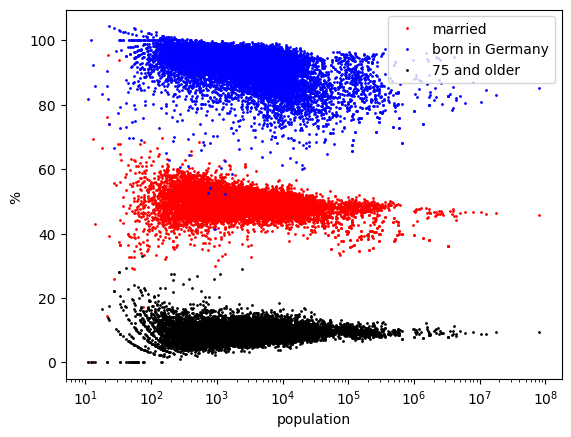

In [70]:

plt.plot(cdf['population'],100*cdf['married_total']/cdf['population'],'o',ms=1,color='red',label='married') 
plt.plot(cdf['population'],100*cdf['birth_country_germany']/cdf['population'],'o',ms=1,color='blue',label='born in Germany')
plt.plot(cdf['population'],100*cdf['total_75_and_older']/cdf['population'],'o',ms=1,color='black',label='75 and older')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("% ")
#plt.yscale("log")
plt.xscale("log")

Some of them are available for nearly all units. Not all of them are fully realiable at low numbers, since there some fraction which larger 100%. These really small communities later for other reasons, thus that is not a problem. 

There were likely slightly changed for data privacy. 
Other data is so unreliable that we excluded it, below we show histograms displaying it. It affects mostly small communities, somewhat larger when the property is rare. 

Text(0.5, 1.0, 'missing or unreliable data')

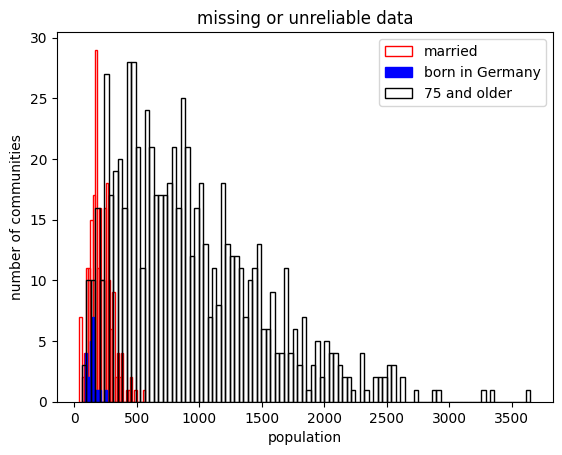

In [82]:
a=cdf.population[cdf['married_total'].isna()]
b=cdf.population[cdf['birth_country_germany'].isna()]
c=cdf.population[cdf['total_75_and_older'].isna()]
plt.hist(a,bins=30,facecolor='None',edgecolor='red',label='married') 
plt.hist(b,bins=10,color='blue',edgecolor='blue',label='born in Germany') 
plt.hist(c,bins=100,facecolor='None',edgecolor='black',label='75 and older') 
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("number of communities")
#plt.yscale("log")
plt.title("missing or unreliable data")

Some properties are only available for large units, usually when population is above 10000, see below. 

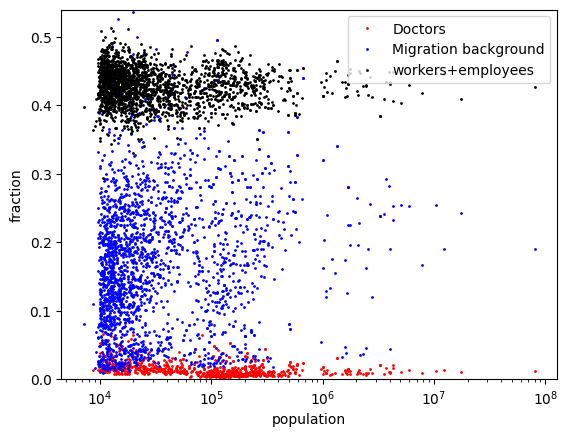

In [86]:
#first plotting takes time 
plt.plot(cdf['population'],cdf['PhD_and_MD']/cdf['population'],'o',ms=1,color='red',label='Doctors') 
plt.plot(cdf['population'],cdf['migration_background_yes']/cdf['population'],'o',ms=1,color='blue',label='Migration background')
plt.plot(cdf['population'],cdf['worker_employee']/cdf['population'],'o',ms=1,color='black',label='workers+employees')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("fraction")
plt.ylim(0,0.54)
#plt.yscale("log")
plt.xscale("log")

Now we load the election data of 2021. That is of last election the (lower) house of Germany which elects the chancellor the most powerful polictican in Germany. 

It is also the last Germany wide election.

In [94]:
wdf=pd.read_csv(path+"btw21_wbz_ergebnisse.csv",sep=';',low_memory=False,skiprows=[1,1])
#row 1 is kind an additional header row
#it is not read well when included and we anyway need to translate the column names, thus we skip it. 
print(wdf.iloc[0:2,0:30].T)

                                                          0                 1
Wahlkreis                                                 1                 1
Land                                                      1                 1
Regierungsbezirk                                          0                 0
Kreis                                                     1                 1
Verbandsgemeinde                                          0                 0
Gemeinde                                                  0                 0
Kennziffer Urnenwahlbezirke nach § 68 BWO              0000              0000
Kennziffer Briefwahlzugehörigkeit                        00                00
Gemeinde Name                              Flensburg, Stadt  Flensburg, Stadt
Wahlbezirk                                               01                02
Bezirksart                                                0                 0
Wahlberechtigte (A)                                    1694     

Then we look on key columns. 

In [ ]:
print(f"There are {wdf.Kreis.nunique()} county keys")
print(f"There {wdf.Land.nunique()} State keys")
print(f"There are {wdf.Regierungsbezirk.nunique()} region keys")

The number of region and counties is clearly smaller than their number in Germany. Thus they are only unique in their region/state. To construct a unique county key we therefore combine the diffeernt keys. 

In [104]:
wdf['e_kreis_id']=wdf.Land*1000+wdf.Regierungsbezirk*100+wdf.Kreis

We are now  looking on the column names and translate the election system ones and the  names of the parties which made it into parliament. 

In the German election every voters has to votes, a vote in the local district for the local representative (person vote below) and a vote for a party list per state, called below party votes.

In the German szstem the party votes is much more important party composition in the house, thus we use it mostly. 
It has also the adventage that the popularity of candiadte does not impact the results as much. 

In [96]:
#Most party names also contain party and Germany, we ommit is usually in the translations
#The keys are ignored as above for the census, as are also minor parties
print(f"columns names before changing {wdf.columns[11:30]}")
print(f"columns names before changing {wdf.columns[51:70]}")
wdf.rename(columns={'Wahlberechtigte (A)':'eligible_voters','Wahlberechtigte mit Sperrvermerk (A2)':'eligible_voters_not_locally' ,'Wahlberechtigte ohne Sperrvermerk (A1)':'eligible_voters_locally','Wahlberechtigte nach § 25 Abs. 2 BWO (A3)':'eligile_voters_added','CDU.1':'christian_democrats_party_votes','CDU':'christian_democrats_person_votes','Wählende (B)':'voters' ,'Wählende mit Wahlschein (B1)':'voters_not_local','Ungültige':'not_valid_person_votes','Gültige':'valid_person_votes','Ungültige.1':'not_valid_party_votes','Gültige.1':'valid_party_votes','SPD.1':'social_democrats_party_votes','SPD':'social_democrats_person_votes','CSU.1':'christian_socials_party_votes','CSU':'christian_socials_person_votes','FDP.1':'libertarians_party_votes','FDP':'libertarians_person_votes','DIE LINKE.1':'lefts_party_votes','DIE LINKE':'lefts_person_votes','AfD.1':'alternative_for_germany_party_votes','AfD':'alternative_for_germany_person_votes','GRÜNE.1':'greens_party_votes','GRÜNE':'greens_person_votes',},inplace=True)
print(f"columns names after changing {wdf.columns[11:30]}")
print(f"columns names after changing {wdf.columns[51:70]}")

columns names before changing Index(['Wahlberechtigte (A)', 'Wahlberechtigte ohne Sperrvermerk (A1)',
       'Wahlberechtigte mit Sperrvermerk (A2)',
       'Wahlberechtigte nach § 25 Abs. 2 BWO (A3)', 'Wählende (B)',
       'Wählende mit Wahlschein (B1)', 'Ungültige', 'Gültige', 'CDU', 'SPD',
       'AfD', 'FDP', 'DIE LINKE', 'GRÜNE', 'CSU', 'FREIE WÄHLER', 'Die PARTEI',
       'Tierschutzpartei', 'NPD'],
      dtype='object')
columns names before changing Index(['LKR', 'SSW', 'Team Todenhöfer', 'UNABHÄNGIGE', 'Volt',
       'Volksabstimmung', 'B*', 'sonstige', 'FAMILIE', 'Graue Panther',
       'KlimalisteBW', 'THP', 'Übrige', 'Ungültige.1', 'Gültige.1', 'CDU.1',
       'SPD.1', 'AfD.1', 'FDP.1'],
      dtype='object')
columns names after changing Index(['eligible_voters', 'eligible_voters_locally',
       'eligible_voters_not_locally', 'eligile_voters_added', 'voters',
       'voters_not_local', 'not_valid_person_votes', 'valid_person_votes',
       'christian_democrats_person_votes

We now look on the elegible voters and the fraction of the largest party. 

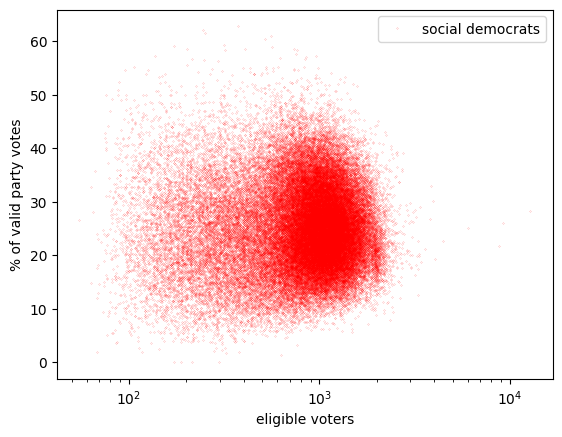

In [98]:
plt.plot(wdf['eligible_voters'],100*wdf['social_democrats_party_votes']/wdf['valid_party_votes'],'o',ms=0.1,color='red',label='social democrats') 
plt.legend(loc="best")
plt.xlabel("eligible voters")
plt.ylabel("% of valid party votes")
#plt.yscale("log")
plt.xscale("log")

The data is per election borough. We now group by Gemeinde to get the smallest level possible in the census data. 

In [324]:
print(f"Shape of election data in boroughs {wdf.shape}")
#group by Gemeinde is either (village,city)  in voter file
wdf2=wdf.groupby(wdf['Gemeinde Name']).sum(numeric_only=True)
#mean is used for numbers which are keys common to Gemeinde
wdf3=wdf.groupby(wdf['Gemeinde Name']).mean(numeric_only=True)#.astype(int)
# we use mean  for numeric key columns
wdf2['Wahlkreis']=wdf3['Wahlkreis']
wdf2['Land']=wdf3['Land']
wdf2['Regierungsbezirk']=wdf3['Regierungsbezirk']
wdf2['Kreis']=wdf3['Kreis']
wdf2['Verbandsgemeinde']=wdf3['Verbandsgemeinde']
wdf2['Gemeinde']=wdf3['Gemeinde']
wdf2['e_kreis_id']=wdf3['e_kreis_id']

print(f"Shape of election data in communities {wdf2.shape}")


Shape of election data in boroughs (94668, 108)
Shape of election data in communities (10955, 103)


We plot again social democrats now on community level. 

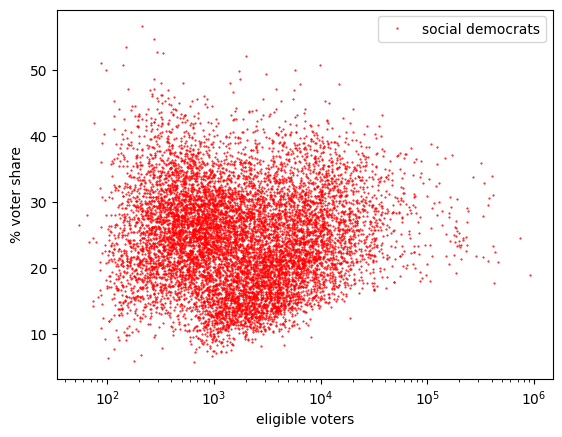

In [325]:
plt.plot(wdf2['eligible_voters'],100*wdf2['social_democrats_party_votes']/wdf2['valid_party_votes'],'o',ms=0.5,color='red',label='social democrats') 
plt.legend(loc="best")
plt.xlabel("eligible voters")
plt.ylabel("% voter share")
#plt.yscale("log")
plt.xscale("log")

The units are clearly bigger. Howver, since there is only one unit larger than a million, Berlin und Hamburg are not properly included. Thus, there are some porblems with some units. 

From the census data we also select the different level data. First community and states which are passed for easier human understanding. We also mark in fromer East and West Germany, since that matters still. 

We also construct a new numeric state key, for which we add the city states to their main neighbor state. We do that that we can use the state key in machine learning, since with only one or two units that is is not possible. 

In [326]:
# communities which will be matched with election data
cdf2=cdf.loc[cdf['Reg_Hier']=='Gemeinde'].copy()
print(f" number of communities {len(cdf2)}")
#now getting Land (Tsate( for getting their names
cdf4=cdf.loc[cdf['Reg_Hier']=='Land'].copy()
cdf4.loc[:,'land_name']=cdf4.loc[:,'Name'].copy() 
cdf4s=cdf4[['RS_Land','land_name']].copy()
cdf4s['quasi_state_key']=cdf4s['RS_Land'].copy()
#set key of city states to neighboring state
#warning are not problems
cdf4s.quasi_state_key[cdf4s.RS_Land==2]=1
cdf4s.quasi_state_key[cdf4s.RS_Land==4]=3
cdf4s.quasi_state_key[cdf4s.RS_Land==11]=12
cdf4s['unification']='West' 
#classify states as existing before and after german unification as east (berlin east here) and west 
cdf4s.unification[cdf4s.RS_Land>10]='East'
print(cdf4s)
cdf2=cdf2.merge(cdf4s,left_on='RS_Land',right_on='RS_Land')  

 number of communities 11339
       RS_Land               land_name  quasi_state_key unification
1            1      Schleswig-Holstein                1        West
1220         2                 Hamburg                1        West
1223         3           Niedersachsen                3        West
2432         4                  Bremen                3        West
2437         5     Nordrhein-Westfalen                5        West
2892         6                  Hessen                6        West
3348         7         Rheinland-Pfalz                7        West
5854         8       Baden-Württemberg                8        West
7004         9                  Bayern                9        West
9164        10                Saarland               10        West
9223        11                  Berlin               12        East
9226        12             Brandenburg               12        East
9717        13  Mecklenburg-Vorpommern               13        East
10622       14     

/tmp/ipykernel_6283/1102387520.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf4s.quasi_state_key[cdf4s.RS_Land==2]=1
/tmp/ipykernel_6283/1102387520.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf4s.quasi_state_key[cdf4s.RS_Land==4]=3
/tmp/ipykernel_6283/1102387520.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf4s.quasi_state_key[cdf4s.RS_Land==11]=12
/tmp/ipykernel_6283/1102387520.py:16: SettingWithCopyWarnin

We o=plot the same properties as before. 

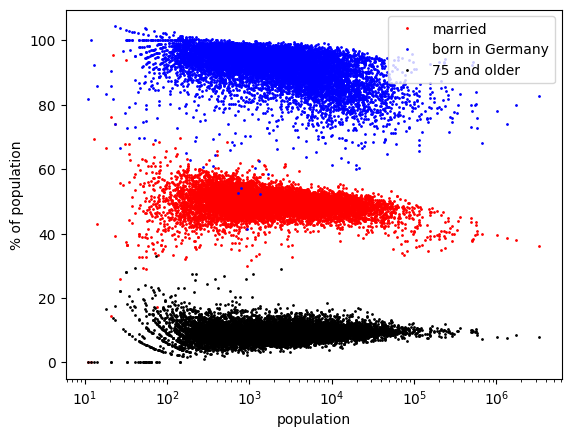

In [327]:

plt.plot(cdf2['population'],100*cdf2['married_total']/cdf2['population'],'o',ms=1,color='red',label='married') 
plt.plot(cdf2['population'],100*cdf2['birth_country_germany']/cdf2['population'],'o',ms=1,color='blue',label='born in Germany')
plt.plot(cdf2['population'],100*cdf2['total_75_and_older']/cdf2['population'],'o',ms=1,color='black',label='75 and older')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("% of population")
#plt.yscale("log")
plt.xscale("log")

The really large units vanished, since they were states and other large units. 


Now we create also in the census data ids for teh county and add also there name

In [328]:
cdf3=cdf.loc[cdf['Reg_Hier']=='Stadtkreis/kreisfreie Stadt/Landkreis'].copy()
print(f"number of Kreis {len(cdf3)}")
#add name 
cdf3.loc[:,'kreis_name']=cdf3.loc[:,'Name']
#create new kreis-id as key because oit is only unique within each Land and RB_NUTS2
cdf3.loc[:,'kreis_id']=cdf3.loc[:,'RS_Kreis']+100*cdf3.loc[:,'RS_RB_NUTS2']+1000*cdf3.loc[:,'RS_Land']
print(f"number of unique Kreis Id {cdf3.kreis_id.nunique()}")
#apply that to communities data frame 
cdf2.loc[:,'kreis_id']=cdf2.loc[:,'RS_Kreis']+100*cdf2.loc[:,'RS_RB_NUTS2']+1000*cdf2.loc[:,'RS_Land']
cdf3s=cdf3[['kreis_id','kreis_name']]
print(f"number of missing Kreis id {cdf3s.kreis_id.isnull().sum()}")
print(f"shape before mergimng {cdf2.shape}")
cdf2=cdf2.merge(cdf3s,left_on='kreis_id',right_on='kreis_id') 
print("Example of some old and new columns.")
print(cdf2.loc[1113:1129,['Name','kreis_name','land_name','kreis_id','population']])
print(f"shape after merging {cdf2.shape}")

number of Kreis 412
number of unique Kreis Id 412
number of missing Kreis id 0
shape before mergimng (11339, 228)
Example of some old and new columns.
                               Name                     kreis_name  \
1113                       Rausdorf                       Stormarn   
1114                        Trittau                       Stormarn   
1115                       Witzhave                       Stormarn   
1116  Hamburg, Freie und Hansestadt  Hamburg, Freie und Hansestadt   
1117            Braunschweig, Stadt            Braunschweig, Stadt   
1118              Salzgitter, Stadt              Salzgitter, Stadt   
1119               Wolfsburg, Stadt               Wolfsburg, Stadt   
1120                 Gifhorn, Stadt                        Gifhorn   
1121                     Sassenburg                        Gifhorn   
1122               Wittingen, Stadt                        Gifhorn   
1123                       Barwedel                        Gifhorn   
1124     

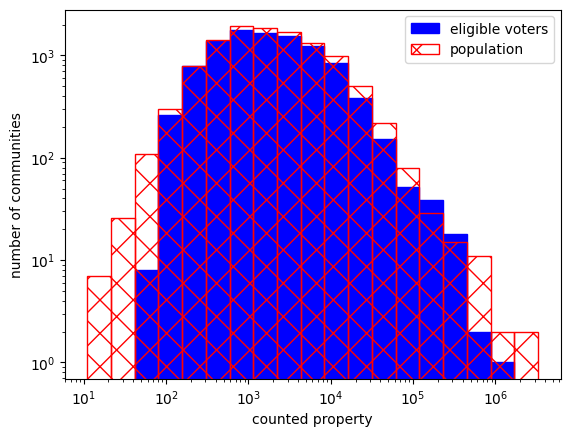

In [329]:
a=cdf2.population
b=wdf2.eligible_voters
logbins = np.geomspace(a.min(), a.max(), 20)
plt.hist(b,bins=logbins,color='blue',edgecolor='blue',label='eligible voters') 
plt.hist(a,bins=logbins,facecolor='None',edgecolor='red',hatch='\\/',label='population') 
plt.legend(loc="best")
plt.xlabel("counted property")
plt.ylabel("number of communities")
plt.yscale("log")
plt.xscale("log")

The histograms of population and eligible voters are similar. The biggest differences areat both ends. Very small villages are missing in the election data. They are likely in larger villages included. They are not so important, since their overall population is small and also the census data on them not so useful.

On the other end there are more larger cities in the population data than in the election data. The largest two cities Hamburg and Berlin are thus certainly split up in the election data. We are also checking other large cities.

In [330]:
print(wdf2.eligible_voters[(wdf2['eligible_voters']>150000)])  

Gemeinde Name
Aachen, Stadt                                                 176306
Augsburg                                                      187164
Berlin, Stadt, Bezirk Charlottenburg-Wilmersdorf (Teil)       217663
Berlin, Stadt, Bezirk Lichtenberg                             200673
Berlin, Stadt, Bezirk Marzahn-Hellersdorf                     197988
Berlin, Stadt, Bezirk Neukölln                                197037
Berlin, Stadt, Bezirk Pankow (Teil)                           285108
Berlin, Stadt, Bezirk Reinickendorf                           176585
Berlin, Stadt, Bezirk Spandau                                 159388
Berlin, Stadt, Bezirk Steglitz-Zehlendorf                     217814
Berlin, Stadt, Bezirk Tempelhof-Schöneberg                    231500
Berlin, Stadt, Bezirk Treptow-Köpenick                        207127
Bielefeld, Stadt                                              234469
Bochum, Stadt (Teil)                                          267771
Bonn, Stadt         

The problem seems to be that to large cities Teil is added in the name. The number of eligible voters and that they are no dulicated indicates that  that most cities complete in contrast to its name. In addition, Berlin and Hamburg are split up into Bezirke (boroughs).  


First we remove the Teil from the city names.

In [331]:
wdf2.reset_index(inplace=True)
s=wdf2[wdf2['Gemeinde Name'].str.contains('Teil')]
print(f"cities with Teil before removing {s['Gemeinde Name']}")
wdf2['Gemeinde Name']=wdf2['Gemeinde Name'].str.replace("Teil","").str.replace("\(\)","").str.strip()
s2=wdf2[wdf2['Gemeinde Name'].str.contains('Teil')]
print(f"{len(s2)} cities with Teil after removing")

cities with Teil before removing 823      Berlin, Stadt, Bezirk Charlottenburg-Wilmersdo...
831                    Berlin, Stadt, Bezirk Pankow (Teil)
1049                                  Bochum, Stadt (Teil)
1230                                  Bremen, Stadt (Teil)
2513                                Dortmund, Stadt (Teil)
2547                                 Dresden, Stadt (Teil)
2561                                Duisburg, Stadt (Teil)
2623                              Düsseldorf, Stadt (Teil)
3012                                   Essen, Stadt (Teil)
3214                       Frankfurt am Main, Stadt (Teil)
4128     Hamburg, Freie und Hansestadt, Bezirk Hamburg-...
4129     Hamburg, Freie und Hansestadt, Bezirk Hamburg-...
4131     Hamburg, Freie und Hansestadt, Bezirk Wandsbek...
4160                     Hannover, Landeshauptstadt (Teil)
5485                                 Krefeld, Stadt (Teil)
5607                                    Köln, Stadt (Teil)
5896                   

/tmp/ipykernel_6283/3053449825.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  wdf2['Gemeinde Name']=wdf2['Gemeinde Name'].str.replace("Teil","").str.replace("\(\)","").str.strip()


No we look on Berlin and Hamburg. We just identify per eye the entries which corresponds to them, since not alll which contain it in the name belong to the city. 

In [332]:
s1=wdf2[wdf2['Gemeinde Name'].str.contains('Hamburg')]
s2=wdf2[wdf2['Gemeinde Name'].str.contains('Berlin')]
print(s1['Gemeinde Name'])
print(s2['Gemeinde Name'])
print(f"column of Name is {s1.columns.get_loc('Gemeinde Name')}")

#sum of values for berlin
ber=wdf2.iloc[823:837,:].sum()
c=wdf2.iloc[823:837,0].count()
#change name and use mean for keys
ber['Gemeinde Name']='Berlin, Stadt'
ber['Wahlkreis']=ber['Wahlkreis']/c
ber['Land']=ber['Land']/c
ber['Regierungsbezirk']=ber['Regierungsbezirk']/c
ber['Kreis']=ber['Kreis']/c
ber['Verbandsgemeinde']=ber['Verbandsgemeinde']/c
ber['Gemeinde']=ber['Gemeinde']/c
print(ber.T)
#same for hamburg
ham=wdf2.iloc[4126:4132,:].sum()
c=wdf2.iloc[4126:4132,0].count()
#change name and keys 
ham['Gemeinde Name']='Hamburg, Freie und Hansestadt'
ham['Wahlkreis']=ham['Wahlkreis']/c
ham['Land']=ham['Land']/c
ham['Regierungsbezirk']=ham['Regierungsbezirk']/c
ham['Kreis']=ham['Kreis']/c
ham['Verbandsgemeinde']=ham['Verbandsgemeinde']/c
ham['Gemeinde']=ham['Gemeinde']/c
print(ham.T)
#append the two new values
wdf2 = wdf2.append(ber, ignore_index=True)
wdf2 = wdf2.append(ham, ignore_index=True)


4126          Hamburg, Freie und Hansestadt, Bezirk Altona
4127       Hamburg, Freie und Hansestadt, Bezirk Bergedorf
4128     Hamburg, Freie und Hansestadt, Bezirk Hamburg-...
4129     Hamburg, Freie und Hansestadt, Bezirk Hamburg-...
4130         Hamburg, Freie und Hansestadt, Bezirk Harburg
4131        Hamburg, Freie und Hansestadt, Bezirk Wandsbek
10401                                  Wentorf bei Hamburg
Name: Gemeinde Name, dtype: object
823      Berlin, Stadt, Bezirk Charlottenburg-Wilmersdorf
824     Berlin, Stadt, Bezirk Friedrichshain-Kreuzberg...
825     Berlin, Stadt, Bezirk Friedrichshain-Kreuzberg...
826                     Berlin, Stadt, Bezirk Lichtenberg
827             Berlin, Stadt, Bezirk Marzahn-Hellersdorf
828               Berlin, Stadt, Bezirk Mitte, Berlin-Ost
829              Berlin, Stadt, Bezirk Mitte, Berlin-West
830                        Berlin, Stadt, Bezirk Neukölln
831                          Berlin, Stadt, Bezirk Pankow
832                   Berlin, 

/tmp/ipykernel_6283/3880237260.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wdf2 = wdf2.append(ber, ignore_index=True)
/tmp/ipykernel_6283/3880237260.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wdf2 = wdf2.append(ham, ignore_index=True)


We change the names of the county independent cities for which we first found no matches. 

In [334]:
# most had somethink added to Stadt, Cotbus also its sorbic name 
wdf2.iloc[8348,0]='Rostock, Hansestadt'
wdf2.iloc[2206,0]='Cottbus, Stadt'
wdf2.iloc[3720,0]='Greifswald, Hansestadt'
wdf2.iloc[4063,0]='Hagen, Stadt'
wdf2.iloc[4318,0]='Heilbronn, Stadt'
wdf2.iloc[6880,0]='Neubrandenburg, Stadt'
wdf2.iloc[9135,0]='Solingen, Stadt'

Now we plot again. 

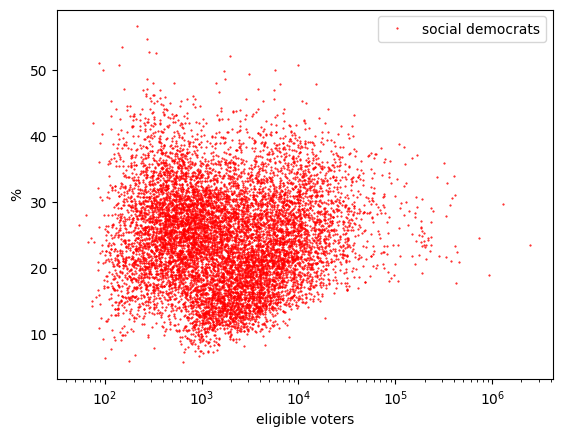

In [335]:
plt.plot(wdf2['eligible_voters'],100*wdf2['social_democrats_party_votes']/wdf2['valid_party_votes'],'o',ms=0.5,color='red',label='social democrats') 
plt.legend(loc="best")
plt.xlabel("eligible voters")
plt.ylabel("%")
#plt.yscale("log")
plt.xscale("log")

Now Berlin and Hamburg are included. 

Now we merge the two data frames. 

In [342]:

comb1=cdf2.merge(wdf2,left_on='Name',right_on='Gemeinde Name')  
print(comb1.shape)

(10034, 333)


In [343]:
print((comb1.kreis_id-comb1.e_kreis_id).describe(percentiles=[0.05,0.1,0.2,0.3,0.5,0.6, 0.7, 0.8, 0.9, 0.95]))#not all match but anyway not really needed, enough when census kreis numbers are fine 

count     10034.000000
mean          1.165376
std        1658.318941
min     -145281.000000
5%          -19.000000
10%           0.000000
20%           0.000000
30%           0.000000
50%           0.000000
60%           0.000000
70%           0.000000
80%           0.000000
90%           0.000000
95%           0.000000
max       15001.000000
dtype: float64


We are first looking on voters properties to check for problems. First, we compare eligible voters and population which should be similar. 

number of communities 10034
number of communities between factor 0.5 and 2: 9683


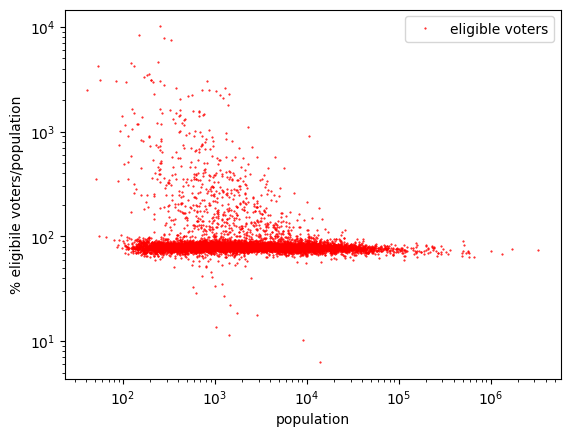

In [344]:
plt.plot(comb1['population'],100*comb1['eligible_voters']/comb1['population'],'o',ms=0.5,color='red',label='eligible voters') 
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("% eligibile voters/population")
plt.yscale("log")
plt.xscale("log")
print(f"number of communities {len(comb1.population)}")
print(f"number of communities between factor 0.5 and 2: {comb1.population[(comb1['eligible_voters']/comb1['population']>0.5) & (comb1['eligible_voters']/comb1['population']<2)].count()}")

Most seem have worked. Some not, but they are rather small and are thus more likely affected by something like changes by changes in the border of communities or name missmatches. 
We are defining the borders per eye which we use the select communities with good data. 

median is 79.4046
16% quantile is 75.068
84% quantile is 85.2139
5% quantile is 71.563
95% quantile is 128.9256
We use as borders 110 to 55
That is a factor 1.3854 larger and a factor 1.4436 smaller than the median.


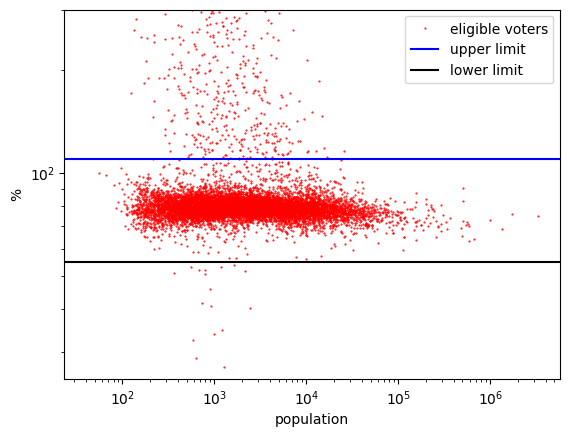

In [345]:
plt.plot(comb1['population'],100*comb1['eligible_voters']/comb1['population'],'o',ms=0.5,color='red',label='eligible voters') 
plt.axhline(y=110, color='b', linestyle='-', label='upper limit')
plt.axhline(y=55, color='k', linestyle='-', label='lower limit')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("%")
plt.yscale("log")
plt.xscale("log")
plt.ylim(25,300)
print(f"median is {round(np.median(100*comb1['eligible_voters']/comb1['population']),4)}")
print(f"16% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],0.1585),4)}")
print(f"84% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],1-0.1585),4)}")
print(f"5% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],0.05),4)}")
print(f"95% quantile is {round(np.quantile(100*comb1['eligible_voters']/comb1['population'],1-0.05),4)}")
print("We use as borders 110 to 55")
print(f"That is a factor {round(110/79.4,4)} larger and a factor {round(79.4/55,4)} smaller than the median.")
#in principlee should be german over 18 but is less complete

We are now looking on the valid votes as function of voters. That checks for communities were votes are mssing because the mail votes were counted elsewhere. Since it is known that the mail votes is diffent from the local vote, those communities are best excluded. We define the border per eye to select the communities with the good data. 

number of communities in census + election data 10034
number of communities in census + election data after excluding population miss matches 9405
number of communities in census + election data after also excluding mssing mail votes 5098
population in census + election data 77204723
population in census + election data after excluding population miss matches 76100656
population in census + election data after also excluding mssing mail votes 71064974


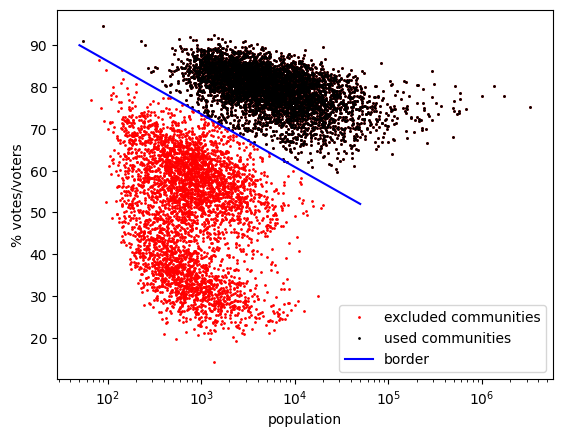

In [346]:
sel=comb1[(abs(100*comb1['eligible_voters']/comb1['population']-82.5)<27.5)].copy()
sel2=comb1[(abs(100*comb1['eligible_voters']/comb1['population']-82.5)<27.5) & (100*comb1['voters']/comb1['eligible_voters']>90-38/3*np.log10(comb1['population']/50))].copy()
li=np.zeros((2,2))
li[0,0]=90
li[0,1]=52
li[1,1]=50000
li[1,0]=50
plt.plot(sel['population'],100*sel['voters']/sel['eligible_voters'],'o',ms=1,color='red',label='excluded communities')
plt.plot(sel2['population'],100*sel2['voters']/sel2['eligible_voters'],'o',ms=1,color='black',label='used communities')
plt.plot(li[1],li[0],'-',ms=1,color='blue',label='border')
plt.legend(loc="best")
plt.xlabel("population")
plt.ylabel("% votes/voters")
#plt.xlim(0,30000)
plt.xscale("log")
print(f"number of communities in census + election data {len(comb1)}")
print(f"number of communities in census + election data after excluding population miss matches {len(sel)}")
print(f"number of communities in census + election data after also excluding mssing mail votes {len(sel2)}")

print(f"population in census + election data {comb1.population.sum()}")
print(f"population in census + election data after excluding population miss matches {sel.population.sum()}")
print(f"population in census + election data after also excluding mssing mail votes {sel2.population.sum()}")

About half the communities are excluded due to the two slection. However, they only consist of about 10% of the population. Oftenk, also the census data is less reliable for the small suuch that the impact on the result below is reduced also due to this aspect. 

The total population is about 8 million less than in should. We now check whather the reason is concentrated in some states (land) or whether it is more a random problem.

completeness per State
land_name
Baden-Württemberg         0.997110
Bayern                    0.994793
Berlin                    1.000000
Brandenburg               0.915416
Bremen                    1.000000
Hamburg                   1.000000
Hessen                    0.931676
Mecklenburg-Vorpommern    0.873715
Niedersachsen             0.963581
Nordrhein-Westfalen       0.956036
Rheinland-Pfalz           0.962308
Saarland                  1.000000
Sachsen                   0.895557
Sachsen-Anhalt            0.981722
Schleswig-Holstein        0.981725
Thüringen                 0.830952
Name: population, dtype: float64
checking for nan
kreis_name
Spree-Neiße                0.164131
Oberspreewald-Lausitz      0.401660
Bautzen                    0.481620
Güstrow                    0.552913
Uelzen                     0.600998
Ilm-Kreis                  0.603773
Groß-Gerau                 0.617514
Wartburgkreis              0.624360
Kyffhäuserkreis            0.626298
Waldeck-Frankenberg   

Text(0, 0.5, 'completenss in election data %')

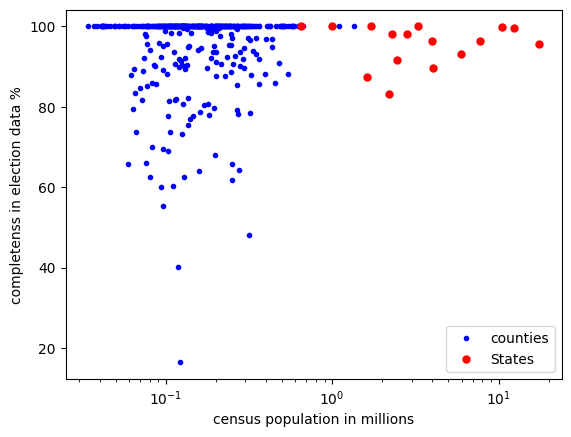

In [347]:
t=cdf2.population.groupby(cdf2['land_name']).sum()
u=comb1.population.groupby(comb1['land_name']).sum()
t2=cdf2.population.groupby(cdf2['kreis_name']).sum()
print("completeness per State")
print(u/t)
u2=comb1.population.groupby(comb1['kreis_name']).sum()
x2=u2/t2
print("checking for nan")
print(x2.sort_values()[0:20])
print("still some low matches")
print(x2.sort_values()[380:422]) #some nan why? and do they matter? robbaly Rostock and co contrinbute to problem 
print("lowest matches are in the region were sorbic names are used also")
plt.plot(t2/10**6,100*u2/t2,'o',ms=3,color='blue',label='counties') 
plt.plot(t/10**6,100*u/t,'o',ms=5,color='red',label='States') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("census population in millions")
plt.ylabel("completenss in election data %")

In [348]:
#checking cities which have nan matches now fine
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Solingen')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Solingen')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Rostock')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Rostock')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Cottbus')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Cottbus')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Greifswald')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Greifswald')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Hagen')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Hagen')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Heilbronn')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Heilbronn')])
s4=wdf2[wdf2['Gemeinde Name'].str.contains('Neubrandenburg')]
print(s4['Gemeinde Name'])
print(cdf2.Name[cdf2['Name'].str.contains('Neubrandenburg')])

9135    Solingen, Stadt
Name: Gemeinde Name, dtype: object
2151    Solingen, Stadt
Name: Name, dtype: object
8348    Rostock, Hansestadt
Name: Gemeinde Name, dtype: object
8902    Rostock, Hansestadt
Name: Name, dtype: object
2206    Cottbus, Stadt
Name: Gemeinde Name, dtype: object
8482    Cottbus, Stadt
Name: Name, dtype: object
3720    Greifswald, Hansestadt
Name: Gemeinde Name, dtype: object
8900    Greifswald, Hansestadt
Name: Name, dtype: object
1314    Briefwahl Amt Hagenow-Land
4060                         Hagen
4061     Hagen am Teutoburger Wald
4062           Hagen im Bremischen
4063                  Hagen, Stadt
4064              Hagenbach, Stadt
4065            Hagenburg, Flecken
4066                  Hagenbüchach
4067                Hagenow, Stadt
Name: Gemeinde Name, dtype: object
867                         Hagen
1523           Hagenburg, Flecken
1587          Hagen im Bremischen
2079    Hagen am Teutoburger Wald
2458                 Hagen, Stadt
4849             Hagenba

There is variation between the states, but all have at least 65% completeness. The smallest completeness is Mechlenburg-Vorpommern where there was a  administration reform affecting communities and county borders. On the county level the completeness is at least about 20%.

For a final check we lookon a known correlation. Catholic against christin union parties. We combine Christain unionsas usual, because they do not compete with each other and form a parlimentary group together

Text(0, 0.5, '% Christian unions')

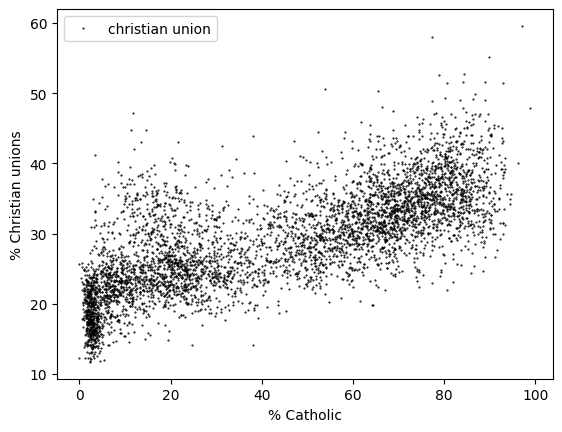

In [349]:

sel2.loc[:,'christian_unions_party_votes']=sel2.loc[:,'christian_socials_party_votes']+sel2.loc[:,'christian_democrats_party_votes']
sel2.loc[:,'christian_unions_person_votes']=sel2.loc[:,'christian_socials_person_votes']+sel2.loc[:,'christian_democrats_person_votes']

plt.plot(100*sel2['religion_catholic']/sel2['population'],100*sel2['christian_unions_party_votes']/sel2['valid_party_votes'],'o',ms=0.5,color='black',label='christian union') 
plt.legend(loc="best")
plt.xlabel("% Catholic")
plt.ylabel("% Christian unions")


As expected there are more votes for the Christian Unions where a large part is Catholic. 

Finally we add all other parties together to be able to look also on them. 

In [350]:
sel2.loc[:,'others_person_votes']=sel2.loc[:,'valid_person_votes']-sel2.loc[:,'christian_unions_person_votes']-sel2.loc[:,'social_democrats_person_votes']-sel2.loc[:,'alternative_for_germany_person_votes']-sel2.loc[:,'libertarians_person_votes']-sel2.loc[:,'greens_person_votes']-sel2.loc[:,'lefts_person_votes']
sel2.loc[:,'others_party_votes']=sel2.loc[:,'valid_party_votes']-sel2.loc[:,'christian_unions_party_votes']-sel2.loc[:,'social_democrats_party_votes']-sel2.loc[:,'alternative_for_germany_party_votes']-sel2.loc[:,'libertarians_party_votes']-sel2.loc[:,'greens_party_votes']-sel2.loc[:,'lefts_party_votes']

Now we write the collected properties of the good matches to be able to work on them in the other notebooks. 

In [351]:
#write to csv to be used by pther programs
sel2.to_csv('census_election_v1.csv')

In addition we use the Kreis level to get some information on the missing properteries for the communities which miss them. 

In [352]:
#census data for kreis

cdf3=cdf.loc[cdf['Reg_Hier']=='Stadtkreis/kreisfreie Stadt/Landkreis'].copy()
print(f"number of Kreis in census data {len(cdf3)}")

#add name 
cdf3.loc[:,'kreis_name']=cdf3.loc[:,'Name']
#create new kreis-id as key because old is only unique within each Land and RB_NUTS2
cdf3.loc[:,'kreis_id']=cdf3.loc[:,'RS_Kreis']+100*cdf3.loc[:,'RS_RB_NUTS2']+1000*cdf3.loc[:,'RS_Land']


u2b=comb1.groupby(comb1['kreis_name']).sum()
#Kreis level census data
print(cdf3.shape)
#should be passed as option to communities where it is not avaialble (o.k. firstsubtract cities)

#why are length slightly different
print(u2b.shape)

cdf3 = cdf3.set_index('kreis_name')

diff=cdf3-u2b

print(cdf2.PhD_and_MD[cdf2.kreis_name=='Breisgau-Hochschwarzwald'])
print(cdf3.PhD_and_MD[cdf3.index=='Breisgau-Hochschwarzwald'])
print(u2b.PhD_and_MD[u2b.index=='Breisgau-Hochschwarzwald'])
print(diff.PhD_and_MD[diff.index=='Breisgau-Hochschwarzwald'])
#belows does not get mssing population unsurprsing, need to get seperately for each property also need to ignore -
print(cdf3.population[cdf3.index=='Breisgau-Hochschwarzwald'])
print(u2b.population[u2b.index=='Breisgau-Hochschwarzwald'])
print(diff.population[diff.index=='Breisgau-Hochschwarzwald'])
#seems work to get it right, I just use the existing columns plus what is also in kreis level to get the others? 
#also -1 are counted currently not right
#something wrong is not final 

number of Kreis in census data 412
(412, 226)
(398, 326)
5825      NaN
5826      NaN
5827      NaN
5828    200.0
5829      NaN
5830      NaN
5831      NaN
5832      NaN
5833      NaN
5834      NaN
5835      NaN
5836      NaN
5837      NaN
5838      NaN
5839    370.0
5840      NaN
5841      NaN
5842      NaN
5843      NaN
5844      NaN
5845      NaN
5846      NaN
5847      NaN
5848      NaN
5849      NaN
5850      NaN
5851      NaN
5852      NaN
5853      NaN
5854      NaN
5855      NaN
5856      NaN
5857      NaN
5858      NaN
5859      NaN
5860      NaN
5861    200.0
5862      NaN
5863      NaN
5864      NaN
5865      NaN
5866      NaN
5867      NaN
5868      NaN
5869      NaN
5870      NaN
5871      NaN
5872      NaN
5873      NaN
5874      NaN
Name: PhD_and_MD, dtype: float64
kreis_name
Breisgau-Hochschwarzwald    3500.0
Name: PhD_and_MD, dtype: float64
kreis_name
Breisgau-Hochschwarzwald    770.0
Name: PhD_and_MD, dtype: float64
kreis_name
Breisgau-Hochschwarzwald    2730.0
Name: P

/tmp/ipykernel_6283/2002310938.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  u2b=comb1.groupby(comb1['kreis_name']).sum()
